Occupancy Tracking 

Author: Paul Ortiz

Contact: paul.ortiz.nm@gmail.com

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import os
import glob
import skimage.morphology
import imageio
import matplotlib.image as mpimg
import cv2
from timeit import default_timer as timer
import skimage.io
import csv
from shapely.geometry import Polygon
from shapely.geometry import Point
from IPython.display import display,clear_output, HTML
import pandas as pd
import datetime


Perspective Warping Functions

create_skewed_image:
Input: Desired frame or image, box that bounds the region of the floor
Output: Image with warped perspective, matrix defining translation parameters

warp_coord(coord,M):
Input: Desired coordinate to be warped, Translation Matrixx



In [56]:
def create_skewed_image(image,box):
    pt_A = box[0]
    pt_B = box[1]
    pt_C = box[2]
    pt_D = box[3]
    
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    maxWidth = int(max(width_AD,width_BC))

    height_AB = np.sqrt(((pt_B[0] - pt_A[0]) ** 2) + ((pt_B[1] - pt_A[1]) ** 2))
    height_CD = np.sqrt(((pt_D[0] - pt_C[0]) ** 2) + ((pt_D[1] - pt_C[1]) ** 2))
    maxHeight = int(max(height_AB,height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])


    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(image,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
    return out,M

def warp_coord(coord,M):
    coord = np.append(np.array(coord),1)
    coor_trans = np.matmul(M,coord)
    warp_x = int(coor_trans[0]/coor_trans[2])
    warp_y = int(coor_trans[1]/coor_trans[2])  
    return (warp_x,warp_y)     



Example of Warping

(800, 1280, 3)


<Figure size 1440x864 with 0 Axes>

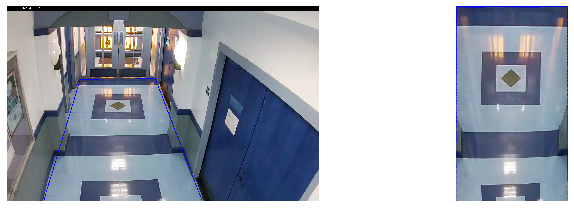

In [57]:
color = (0, 0, 255)
thickness = 2

plt.figure(figsize=(20,12))
intial_frame = cv2.imread(r'F:\Thomas and Brown Data\intial_frames\intial_frame_se.png')
# intial_frame_se_2 = cv2.imread(r'C:\Users\P Dog\Downloads\intial_frame_se_cap_2.png')
print(np.shape(intial_frame))
# pad_se = np.zeros((np.shape(intial_frame_se)[0]+600,np.shape(intial_frame_se)[1]+600,3)).astype(np.uint8)
# pad_se[:,:,0] = np.pad(intial_frame_se[:,:,0],300)
# pad_se[:,:,1] = np.pad(intial_frame_se[:,:,1],300)
# pad_se[:,:,2] = np.pad(intial_frame_se[:,:,2],300)

#Define points of floor region
p1 = (300, 300)
p2 = (150, 799)
p3 = (800,799)
p4 = (608, 298)

#Points arranged into list
box = [p1,p2,p3,p4]

#Draw lines for boundry
intial_frame = cv2.line(intial_frame, p1, p2, color, thickness)
intial_frame = cv2.line(intial_frame, p1, p4, color, thickness)
intial_frame = cv2.line(intial_frame, p3, p4, color, thickness)

#Return image and warp matrix
skew,M = create_skewed_image(intial_frame,box)

plt.rcParams["figure.figsize"] = [10, 3]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(nrows=1, ncols=2,gridspec_kw={'wspace':0, 'hspace':0})

ax[0].axis('off')
ax[0].imshow(intial_frame, cmap='gray')
ax[1].axis('off')
ax[1].imshow(skew, cmap='gray')



Interpret CSV files
These files contain the x,y coordinates of the bottom of each occupant. The format of the file is very specific. It can be improved but a file that does not follow the format will not be loaded correctly. A sample is given in the repo.

interpret_csv_data:
Input file with specific format and return matrix of all occupant's locations and timestamps

In [58]:
def interpret_csv_data(file_path):
    detection_mat = []
    max_in_frame = 0
    with open(file_path, newline='') as csvfile:
        det_row = []
        reader = csv.reader(csvfile)

        for row in reader:


            if len(row)>max_in_frame:
                max_in_frame = len(row)
            if len(row)>1:
                det_row = [(row[0])]

                for i in range(1,len(row)):
                    split = row[i].split(',')
                    c1 = ''
                    c2 = ''
                    for val in split[0]:
                        if val.isdigit():
                            c1+=val
                    c1 = int(c1)
                    for val in split[1]:
                        if val.isdigit():
                            c2 += val
                    c2 =int(c2)
                    det_row+=[(c1,c2)]
            else:
                det_row = [(row[0])]
                

            detection_mat += [det_row]
            
        return detection_mat
 

Example of interpreting csv

In [59]:
csv_file_name = r'C:\Users\P Dog\Downloads\two_subjects.csv'
print(csv_file_name)
format_sample = interpret_csv_data(r'C:\Users\P Dog\Downloads\SW Exit 11.08.2021 Rec 1 Stamped.csv')     
print(format_sample[0:10]) 

C:\Users\P Dog\Downloads\two_subjects.csv
[[''], [''], [''], [''], [''], [''], ['', (47, 795)], [''], [''], ['', (52, 796)]]


In bounds calculation

poly_bound: Find if point is within a specified polygon
Input: Desired Coordinate, Bounds to check
Output: T/F if point in bounds



In [60]:
def poly_bound(coord, regions):
    coord = Point(coord)
    for region in regions:
        poly = Polygon(region)
        if poly.contains(coord):
            return True

    return False


Example 1:
Point is in polygon

Example 2: 
Point is outside polygon

Is in bound?: True


(-0.5, 99.5, 99.5, -0.5)

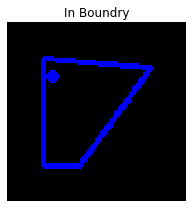

In [61]:
def calculate_distance(p1,p2):
    x = p1[0]-p2[0]
    y = p1[1]-p2[1] 
    euclid = np.sqrt(x**2+y**2)
    return euclid


sample = np.zeros((100,100,3))
p1 = (20,20)
p2 = (80,25)
p3 = (40,80)
p4 = (20,80)
coord = (25,30)
poly = [[p1,p2,p3,p4]]

cv2.circle(sample, coord, 2, (0, 0,255), 2)
cv2.line(sample, p1, p2, (0,0,255), thickness)
cv2.line(sample, p2, p3, (0,0,255), thickness)
cv2.line(sample, p3, p4, (0,0,255), thickness)
cv2.line(sample, p4, p1, (0,0,255), thickness)
plt.title("In Boundry")
plt.imshow(sample.astype(np.uint8))

print("Is in bound?:",poly_bound(coord,poly));plt.axis('off')
    



    

Is in bound?: False


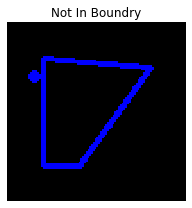

In [62]:
sample = np.zeros((100,100,3))
p1 = (20,20)
p2 = (80,25)
p3 = (40,80)
p4 = (20,80)
coord = (15,30)
poly = [[p1,p2,p3,p4]]

cv2.circle(sample, coord, 2, (0, 0,255), 2)
cv2.line(sample, p1, p2, (0,0,255), thickness)
cv2.line(sample, p2, p3, (0,0,255), thickness)
cv2.line(sample, p3, p4, (0,0,255), thickness)
cv2.line(sample, p4, p1, (0,0,255), thickness)
plt.title("Not In Boundry")
plt.imshow(sample.astype(np.uint8));plt.axis('off')

def poly_bound(coord, regions):
    coord = Point(coord)
    for region in regions:
        poly = Polygon(region)
        if poly.contains(coord):
            return True

    return False

print("Is in bound?:",poly_bound(coord,poly))

Class: People
Handles all data related to occupants location and hallway data

In [89]:
class People:

    def __init__(self):
        self.file_name = ''
        self.person = { }
        self.buffer = { }
        self.trajectory = { }
        self.exits = {'main':str()}
        self.hallway = {'main':str()}
        self.rooms = {'':np.array([])}
        self.total = 0
        self.event_total = 0
        self.bound = {}

        self.hall_name = ''
        self.time = []
        self.time_interval = ''
        

    #Add names of exits
    def add_exits(self,bound_coords,name):
        self.exits[name]=bound_coords
    
    #Add names of Hallways
    def add_hallway(self,bound_coords,name):
        self.hallway[name]=bound_coords
        
    #Create New Person Object
    def add_person(self,person_cont):
        self.person[person_cont] = np.array([])
        self.buffer[person_cont] = 0
        self.trajectory[person_cont] = 0

#         self.total += 1

    #Delete Person Object    
    def delete_person(self, person_num):
        self.person.pop(person_num)
        self.buffer.pop(person_num)
        self.trajectory.pop(person_num)

    #Append New Coordinates  
    def add_coord_to_person(self, person_num, coords):
        people.person[person_num] = np.append(people.person[person_num],coords)
#         self.calc_total()
    
    #Reset Person Object 
    def reset_person(self,person_cont):
        self.person[person_cont]= np.array([])


    #Set interval of time occupant was in frame
    def calculate_time_interval(self,time_vect):
        total_seconds_array = np.array([])
        for time in time_vect:
            time = time[0]
            time = time.replace('O','0')


            try:

                time_in_seconds = int(time[0]+time[1])*60*60 + int(time[3]+time[4])*60 + int(time[6]+time[7])

            except:
                continue

            total_seconds_array = np.append(total_seconds_array,np.array([time_in_seconds])) 

        if len(total_seconds_array)==0:
            pass
        else:
            # print('Start:',str(datetime.timedelta(seconds=np.min(total_seconds_array))))
            # print('Stop:',str(datetime.timedelta(seconds=np.max(total_seconds_array))))

            return [np.min(total_seconds_array),np.max(total_seconds_array)]



    #Run trough each bound and assign intial and final detection point
    def process_position(self,location,person_data,i,EXIT,HALLWAY,OFFICE):
        print()
        if self.buffer[i]==7:
            pass
#             self.delete_person(i)


    

        elif(len(person_data)>30):
            tip=''
            tail=''
            p_stop = (int(person_data[-2]), int(person_data[-1]))
            p_start  = (int(person_data[0]), int(person_data[1]))
            for exit in EXIT:
                if poly_bound(p_start, [exit]):
                    tail = 'exit'
                if poly_bound(p_stop, [exit]):
                    tip = 'exit'


            for hall in HALLWAY:
                if poly_bound(p_start, [hall]):
                    tail = 'hall'
                if poly_bound(p_stop, [hall]):
                    tip = 'hall'
                


            for office in OFFICE:
                if poly_bound(p_start, [office]):
                    tail = 'office'
                if poly_bound(p_stop, [office]):
                    tip = 'office'


            #Calculate bounds
            time_interval = self.calculate_time_interval(self.time)
            print(time_interval)
            # self.time = []
            total_displacment = (person_data[-2]-person_data[0],(person_data[1]-person_data[-1]))

            #Trajectory Check, Unused
            # if total_displacment[0] == 0:
            #     pass
            # elif ((total_displacment[0]<0) or (total_displacment[0]<0)):
            #     self.trajectory[i]=(np.pi + np.arctan(total_displacment[1]/total_displacment[0]))
            # else:
            #     self.trajectory[i]=(np.arctan(total_displacment[1]/total_displacment[0]))
            #     if self.trajectory[i]<0:
            #         self.trajectory[i]= 2*np.pi + self.trajectory[i]
    
            location.assign_event(tip,tail,self.hall_name,time_interval)
            self.reset_person(i)
            
        #Delete short error paths from false detection
        else:
            self.reset_person(i)

        
        

Location Handler: Handles total locations and records occupants locations

In [96]:
class LocationHandler:
    def __init__(self):
        self.total_data = pd.DataFrame(columns=['start','stop','known','ambigious','location'])
        self.global_count = 0
        self.ambigious = 0
        self.time = 0
        self.known = 0


    #Tally total
    def tally(self):
        self.global_count = self.ambigious + self.known
        # print('Total:',self.global_count)
        # print('Known:',self.known)
        # print('Ambigious:',self.ambigious)


    #Determine event in frame from intial and final point labels
    def assign_event(self, tip, tail,location,time_interval):
        self.known = 0
        self.ambigious = 0
        if (( tail == 'exit' )&(tip == 'hall')):
            self.ambigious =1
            self.known = 0
            print('Entered Hallway: Location Ambigious')

        elif (( tail == 'exit' )&(tip == 'office')):
            self.known =1
            self.ambigious = 0
            print('Entered Office: Quadrent {}'.format(location))


        elif (( tail == 'exit' )&(tip == 'exit')):
            self.ambigious = 0
            self.known = 0
            print('Exit to Exit Transition')

        
        elif (( tail == 'hall' )&(tip == 'hall')):
            self.amibigious = 0
            self.known = 0
            print('Hallway to Hallway Transition')

        elif (( tail == 'hall' )&(tip == 'office')):
            self.ambigious = 0
            self.known =1
            print('Hallway to Office: Quadrent {}'.format(location))

        elif (( tail == 'hall' )&(tip == 'exit')):
            self.ambigious = -1
            self.known = 0
            print('Hall to Exit: Departed')

        elif (( tail == 'office' )&(tip == 'hall')):
            self.known =-1
            self.ambigious =0
            print('Office to Hall: Location Ambigious')


        elif (( tail == 'office' )&(tip == 'office')):
            self.known = 0
            self.ambigious = 0
            print('Office to Office transition: Quadrent {}'.format(location))

        elif (( tail == 'office' )&(tip == 'exit')):
            self.known = -1
            self.ambigious = 0
            print('Office to Exit: Departed')

        else:
            print('Error')



        row=[time_interval[0],time_interval[1],self.known,self.ambigious,location]
        self.total_data.loc[len(self.total_data)]= row
        clear_output(wait=True)
        display(self.total_data)

#final step to write out data
def write_out_data(data, filename):
    print(file_name)
    data.to_csv(filename+' Data.csv',encoding='utf-8',index = False)

Main Detection Loop

In [95]:
#SE Hallway

#Name and location of final occupancy data list
file_name = r'F:\Goddard Annex Week Final Blurred\Final Data TPR\sample'

#Read in CSV files of interpretations
detection_mat = interpret_csv_data(r'F:\Goddard Annex Week Final Blurred\CSVs\01 27 22 SE blurred.csv') 

#Video
cap = cv2.VideoCapture(r'F:\Goddard Annex Week Final Blurred\SE\01 27 22 SE blurred.avi')

#Grab first and second frame
ret, frame1 = cap.read()
ret, frame2 = cap.read()
empty_frame_count = 0
frame_count = 0
total = 0
path_history = []
people = People()
location = LocationHandler()

pt_A = (300, 300)
pt_B = (150, 770)
pt_C = (800,770)
pt_D = (608, 298)


box_se = [pt_A,pt_B,pt_C,pt_D]

skew,M = create_skewed_image(intial_frame,box_se)
map= np.zeros(np.shape(skew))


people.file_name = file_name

# 800, 1280
people.hall_name = 'SE'



#Bounding Polygons
SE_EXIT    = [ [(325, 0),(580,0), (580, 325), (325, 325)]]

#Place holder, can be used from more specific locations
SE_OFFICE  = [ [(0,0),(0,1),(1,1),(1,0)] ]


SE_HALLWAY = [ [(0,326),(1280,326),(1280,801),(0,801)]  ]

while cap.isOpened():
    g_map = cv2.imread(r'C:\Users\P Dog\downloads\map_sample.png')
    min_index = []
    distance = []
    index = []
    pop_index = []
    trans_coords = detection_mat[frame_count][1:]



    # Read detectons and add a person if there are more coords tahn people
    if len(detection_mat[frame_count])>1:
        people.time += [[detection_mat[frame_count][0]]]  
        empty_frame_count = 0
        num_det = len(detection_mat[frame_count])-1

        if num_det > len(people.person):
            people.add_person(num_det-1)

                  
        for i in range(len(trans_coords)):
            people.buffer[i]=0

            people.add_coord_to_person(i,trans_coords[i])
            

            
    # If there is no coordinate for a person increase the buffer by one
        if num_det < len(people.person):
            diff = len(people.person)-num_det
            for k in range(i+1, diff+1):
#                 if len(people.person[k])>0:
#                     people.add_coord_to_person(k, (people.person[k][-2], people.person[k][-1]))
                
                people.buffer[k]+=1             

    # Calculate the distance each point is from the incomming points 
        trans_coords = detection_mat[frame_count][1:]
        for i in range(len(trans_coords)):
            for keys in people.person.keys():
                if len(people.person[keys])> 2:
                    distance += [(calculate_distance((people.person[keys][-4],people.person[keys][-3]), trans_coords[i]))]

    # Create an vector of each distance and grab the index of the closest point
        if (i>0 and len(distance)>1):

            distance = np.array(distance)
            distance = np.split(distance, i+1)
            
            
    # Scan trough a choose a point for a person and make that point invalid for the next person
            for j in range(len(distance)):
                min_index = np.where(distance[j]==np.min(distance[j]))
                current_dex = int(min_index[0][0])
                index += [current_dex]
                for k in range(len(distance)):
                    
                    distance[k][current_dex] = np.infty

                    

    # Reset the buffer if the person receives a point and add the chosen point
            
            for i in range(1,len(index)+1):
                if len(index) == len(set(index)):
                    try:
                        people.person[i-1][-1] = trans_coords[index[i-1]][-1]
                        people.person[i-1][-2] = trans_coords[index[i-1]][-2]
                    except:
                        pass
                    
    # Draw an arrow along the path of the person
            


    # Draw a circle at each given point
        for key in people.person.keys():
            if len(people.person[key])>2:
                trans_coord = warp_coord((people.person[key][-2],people.person[key][-1]),M)


        for keys in people.person.keys():
                if len(people.person[keys])>4:
                    p1 = (int(people.person[keys][-4]),int(people.person[keys][-3]))
                    p2 = (int(people.person[keys][-2]),int(people.person[keys][-1]))
                    p1 = warp_coord(p1, M)
                    p2 = warp_coord(p2, M)
                    cv2.arrowedLine(map,p1,p2, (255,255,0), thickness,tipLength = 0.5)

    elif( len(people.person)>0 & len(detection_mat[frame_count])<1 ):
        empty_frame_count +=1
        for keys in people.person.keys():
            people.buffer[keys] += 1
            
    elif(len(detection_mat[frame_count])==1):
        empty_frame_count +=1

            

    # Process the given detections and calc the total
    person_keys = list(people.person.keys())

    if ((empty_frame_count == 20) & (len(people.person)>0)):


        for keys in person_keys:
            people.process_position(location,people.person[keys],keys,SE_EXIT,SE_HALLWAY,SE_OFFICE)
            map= np.zeros(np.shape(skew))
        location.tally()
        
        people.time = []
        

    #Displace the hall and trasformed overhead view
#     frame1 = cv2.GaussianBlur(frame1, (11,11), 5)
    blur1 = cv2.GaussianBlur(frame1, (11,11),7)
    blur2 = cv2.GaussianBlur(frame2, (11,11),7)
    diff = cv2.absdiff(blur1, blur2)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 15, 150, cv2.THRESH_BINARY)

    #Translate onto floor plan
    g_map[310:1020,510:710:] = 255
    g_map[310:1020,510:710:] = g_map[310:1020,510:710:] - cv2.flip(cv2.resize(map,( int(200) ,int(710) )),-1)
    
    #Show map and video feed
    cv2.imshow("Map", g_map.astype(np.uint8))
    cv2.imshow("Feed",frame1)
    
    



    #Reset frames
    frame1 = frame2 

    ret, frame2 = cap.read()

    if frame2 is None: 
        
        for keys in person_keys:

            people.process_position(location,people.person[keys],keys,SE_EXIT,SE_HALLWAY,SE_OFFICE)

        write_out_data(location.total_data,file_name)    

        break    
    frame_count+=1
    


#Set wait lower to speed up video
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()


Final Occupancy Plot:
Take all data from each hallway and combine it into one plot

['01 28 22 N blurred Data.csv', '01 28 22 SE blurred Pt1 Data.csv', '01 28 22 SE blurred Pt2 Data.csv', '01 28 22 SW blurred Pt1 Data.csv', '01 28 22 SW blurred Pt2 Data.csv']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and swi

<StemContainer object of 3 artists>

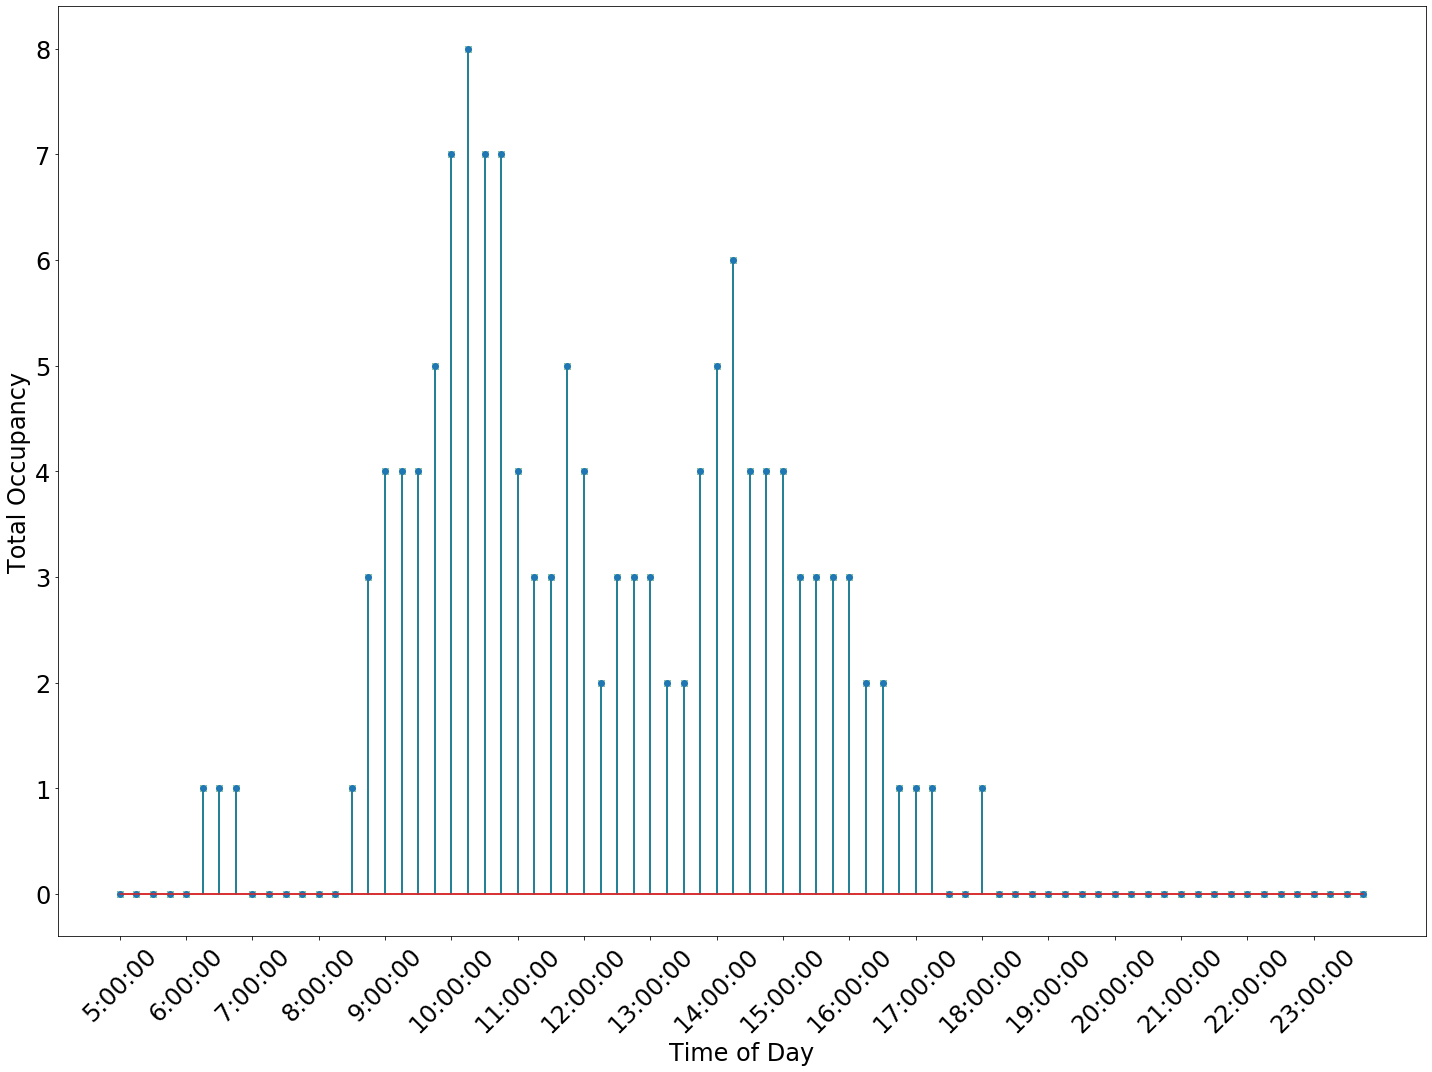

In [99]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

plt.figure(figsize=(20,15))
data_directory_name = r'F:\Goddard Annex Week Final Blurred\Final Data Output\01 28 22'
directory = os.listdir(data_directory_name)
all_events = pd.DataFrame({})
print(directory)
for hallway_event in directory:

    event = pd.read_csv(data_directory_name + '/' + hallway_event)
    
    all_events = all_events.append(event)
all_events = all_events.sort_values(by=['start'])
all_events = all_events.reset_index(drop = True )



time_change = all_events.copy()
for i in range(len(time_change['start'])):
    time_change['start'].iloc[i] = str(datetime.timedelta(seconds=time_change['start'].iloc[i]))
for i in range(len(time_change['stop'])):
    time_change['stop'].iloc[i] = str(datetime.timedelta(seconds=time_change['stop'].iloc[i]))

x = 0

intial_time = all_events['start'][0]

for i in range(len(all_events['ambigious'])):
    
    x = x  + (all_events['ambigious'][i])



y_axis = [] 
x_axis = []

for i in range(18000,86400,900):
    w = (np.where(all_events['start']<i))

    x = 0
    for j in w[0]:
        if x  + (all_events['ambigious'][j]) <0:
            print('Occupancy Invalid Low: Resetting Count')
        else:
            x = x  + (all_events['ambigious'][j])

            
    y_axis += [x]
    x_axis += [str(datetime.timedelta(seconds=i))]

plt.stem(x_axis,y_axis,'g',markerfmt='gx', label='Unrestricted Confidence')
plt.xticks(rotation = 45,fontsize=24)
plt.xticks(np.arange(0, 76, step=4))
plt.yticks(fontsize=24)
plt.xlabel('Time of Day',fontsize=24)
plt.ylabel('Total Occupancy',fontsize=24)
plt.stem(x_axis,y_axis, label='Restricted Confidence: 0.97')
